# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [4]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # normalize to mean=0.5, std=0.5 (grayscale only has 1 channel)
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### I applied three preprocessing steps:

**Convert to Tensor (ToTensor):** This changes the raw image data into PyTorch tensors with values scaled between 0 and 1. Neural networks in PyTorch require tensor inputs.

**Normalize (Normalize((0.5,), (0.5,)))** This rescales the pixel values to approximately the range (-1, 1). Normalization improves training stability and convergence since the model weights don’t need to adapt to very large or uncentered input values.

**Flatten (Lambda(lambda x: x.view(-1))):** Each MNIST image is 28×28 pixels. Since I am using a fully connected neural network (not a convolutional network), the model expects a 1D feature vector. Flattening converts each image into a 784-dimensional vector.

#### These preprocessing steps are necessary to make the dataset compatible with the chosen network architecture and to help the training process converge efficiently.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


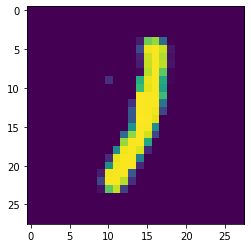

3


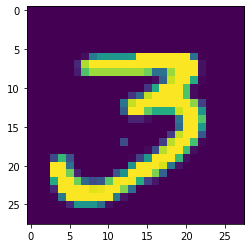

7


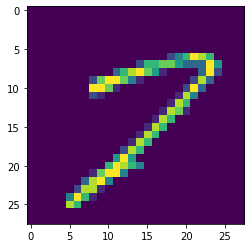

7


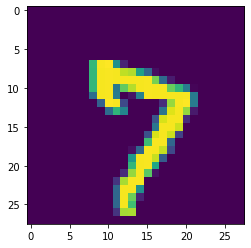

3


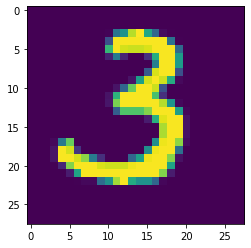

Number of training samples: 60000
Number of test samples: 10000
Batch images shape (with preprocessing): torch.Size([64, 784])
Batch labels shape: torch.Size([64])
Single image shape (flattened): torch.Size([784])


In [8]:
# Explore data

# For visualization: use only ToTensor() so images are not normalized or flattened
transform_vis = transforms.Compose([
    transforms.ToTensor()
])

# Create a separate dataset + loader for visualization
trainset_vis = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_vis
)
trainloader_vis = DataLoader(trainset_vis, batch_size=64, shuffle=True)

# Show 5 images using the provided function
show5(trainloader_vis)

# Print number of samples in both training and test sets
print("Number of training samples:", len(trainset))
print("Number of test samples:", len(testset))

# Explore dimensions of a batch (with preprocessing)
images, labels = next(iter(trainloader))
print("Batch images shape (with preprocessing):", images.shape)
print("Batch labels shape:", labels.shape)

# Example: shape of a single flattened image
print("Single image shape (flattened):", images[0].shape)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 784 (28x28 flattened)
        self.fc1 = nn.Linear(784, 256)   # first hidden layer
        self.fc2 = nn.Linear(256, 128)   # second hidden layer
        self.fc3 = nn.Linear(128, 64)    # third hidden layer
        self.fc4 = nn.Linear(64, 10)     # output layer (10 classes: digits 0–9)

    def forward(self, x):
        # Apply ReLU activation after each hidden layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Output layer (raw scores -> CrossEntropyLoss will handle softmax)
        x = self.fc4(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()  
# (standard choice for multi-class classification)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model.to(device)

# Training parameters
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # set model to training mode
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass + update
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print every 250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
    
    # Average training loss for the epoch
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    
    # Validation accuracy after each epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}] -> Avg Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

Using device: cuda
Epoch [1/10], Step [250/938], Loss: 0.4656
Epoch [1/10], Step [500/938], Loss: 0.2012
Epoch [1/10], Step [750/938], Loss: 0.1627
Epoch [1/10] -> Avg Loss: 0.3647, Validation Accuracy: 94.68%
Epoch [2/10], Step [250/938], Loss: 0.0858
Epoch [2/10], Step [500/938], Loss: 0.1285
Epoch [2/10], Step [750/938], Loss: 0.1715
Epoch [2/10] -> Avg Loss: 0.1583, Validation Accuracy: 95.70%
Epoch [3/10], Step [250/938], Loss: 0.0665
Epoch [3/10], Step [500/938], Loss: 0.1703
Epoch [3/10], Step [750/938], Loss: 0.1664
Epoch [3/10] -> Avg Loss: 0.1172, Validation Accuracy: 96.65%
Epoch [4/10], Step [250/938], Loss: 0.1482
Epoch [4/10], Step [500/938], Loss: 0.0519
Epoch [4/10], Step [750/938], Loss: 0.2795
Epoch [4/10] -> Avg Loss: 0.0956, Validation Accuracy: 96.22%
Epoch [5/10], Step [250/938], Loss: 0.2335
Epoch [5/10], Step [500/938], Loss: 0.0323
Epoch [5/10], Step [750/938], Loss: 0.0622
Epoch [5/10] -> Avg Loss: 0.0852, Validation Accuracy: 96.47%
Epoch [6/10], Step [250/93

Plot the training loss (and validation loss/accuracy, if recorded).

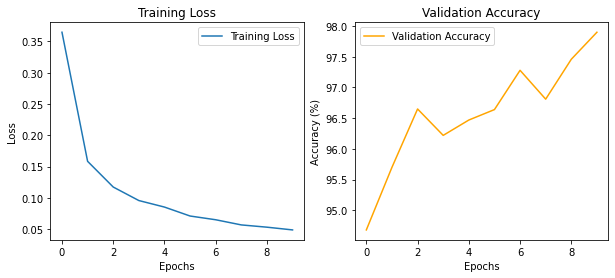

In [8]:
# Plot training loss and validation accuracy
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
# Evaluate on the test set
model.eval()  # set model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # highest probability class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 97.90%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [10]:
# Re-train the original model with tuned hyperparameters

# Reset optimizer with a smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Increase number of epochs
epochs = 15
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    
    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}] -> Avg Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Best Validation Accuracy:", max(val_accuracies))

Epoch [1/15] -> Avg Loss: 0.0272, Validation Accuracy: 98.08%
Epoch [2/15] -> Avg Loss: 0.0203, Validation Accuracy: 97.95%
Epoch [3/15] -> Avg Loss: 0.0189, Validation Accuracy: 97.75%
Epoch [4/15] -> Avg Loss: 0.0170, Validation Accuracy: 97.75%
Epoch [5/15] -> Avg Loss: 0.0143, Validation Accuracy: 97.80%
Epoch [6/15] -> Avg Loss: 0.0164, Validation Accuracy: 97.94%
Epoch [7/15] -> Avg Loss: 0.0123, Validation Accuracy: 97.85%
Epoch [8/15] -> Avg Loss: 0.0139, Validation Accuracy: 97.86%
Epoch [9/15] -> Avg Loss: 0.0108, Validation Accuracy: 97.58%
Epoch [10/15] -> Avg Loss: 0.0101, Validation Accuracy: 98.14%
Epoch [11/15] -> Avg Loss: 0.0105, Validation Accuracy: 98.20%
Epoch [12/15] -> Avg Loss: 0.0127, Validation Accuracy: 97.90%
Epoch [13/15] -> Avg Loss: 0.0099, Validation Accuracy: 97.95%
Epoch [14/15] -> Avg Loss: 0.0108, Validation Accuracy: 97.48%
Epoch [15/15] -> Avg Loss: 0.0082, Validation Accuracy: 98.25%
Best Validation Accuracy: 98.25


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
# Save the improved model (or replace with `model` if you want the original one)
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to mnist_model.pth
